In [41]:
import numpy as np
from scipy.signal import butter, lfilter, iirnotch, find_peaks, filtfilt
import matplotlib.pyplot as plt

In [38]:
data = [signal.rstrip('\n') for signal in open('DataN.txt')]
missing_beats_data = [signal.rstrip('\n') for signal in open('Data2.txt')]
d = [signal.rstrip('\n') for signal in open('Data2.txt')]
signals = []
missing_beats_signals = []

for signal in data:
    signals.append(float(signal))

for signal in missing_beats_data:
    missing_beats_signals.append(float(signal))
    
time_axis = np.linspace(0,4*len(signals), len(signals));

In [43]:
def notch_filter(noisy_signals, sampling_rate, dc_component: int=50, quality_factor: int = 30):
    
    b, a = iirnotch(dc_component, quality_factor, sampling_rate)
    noise_free_signals = filtfilt(b, a, noisy_signals)
    
    return noise_free_signals

In [42]:
def butter_bandpass_filter(noisy_signals, sampling_rate,lowcut: float=0.1, highcut: float= 45.0, order: int = 2):
    nyq = 0.5 *sampling_rate
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    noise_free_signals = filtfilt(b, a, noisy_signals)

    return noise_free_signals

In [28]:
def filter_noise(noisy_signals, low_cut_frequncy,
                 high_cut_frequncy, sample_rate, dc_component):
    
    dc_component_removed = notch_filter(noisy_signals,
                                        sample_rate, dc_component)
    
    noise_free_signals = butter_bandpass_filter(dc_component_removed,
                                                sample_rate,
                                                low_cut_frequncy,
                                                high_cut_frequncy)
    return noise_free_signals
    

In [14]:
def derivatise(signals):
    filterd_signals= np.zeros((len(signals)))
    filterd_signals[0:2] = signals[0:2]

    T = 1/256
    for s in range(2,len(signals)-2):
        op = -2*(signals[s-1])
        op -= ((signals[s-2]))
        op += (signals[s+2])
        op += (2*(signals[s+1]))
        op *= (1/(8*T))
        filterd_signals[s] += op
    
    return filterd_signals

In [15]:
def square(differentiated_signals):
    squared_signals = []
    for signal in differentiated_signals:
        squared_signals.append(np.square(signal))
    return squared_signals     

In [16]:
def smoothen(squared_signals, window_size):
    smoothed_signals = np.zeros((len(squared_signals)))
    smoothed_signals[0:window_size] = squared_signals[0:window_size]
    starting_index = window_size-1
    for signal in range(starting_index, len(squared_signals)):
        for index in range(0, window_size):
            smoothed_signals[signal] += (squared_signals[signal-index])
        smoothed_signals[signal] /= window_size
    return smoothed_signals

In [50]:
def set_threshold(signals, N):
    maximum_signal = max(signals)
    threshold = maximum_signal/N  
    return threshold  

In [18]:
def R_indices(signals, threshold, distance: int=150):
    R_waves= find_peaks(signals,height= threshold, distance= distance )
    return R_waves    

In [19]:
def R_peaks(signals, peak_indices):
    R_peaks = []
    for index in peak_indices:
        R_peaks.append(signals[index])          
    return R_peaks

In [20]:
def ECG_plotting_analysis(signals, window_size):
    
    differentiated_signals = derivatise(signals)
    squared_signals = square(differentiated_signals)
    smoothed_signals = smoothen(squared_signals,window_size)
    threshold = set_threshold(smoothed_signals, window_size)
    
    RR_indices = R_indices(smoothed_signals, threshold)
    RR_peaks = R_peaks(smoothed_signals, RR_indices[0])
    
    return RR_peaks, smoothed_signals, RR_indices

In [21]:
def ECG(signals, window_size):
    
    differentiated_signals = derivatise(signals)
    squared_signals = square(differentiated_signals)
    smoothed_signals = smoothen(squared_signals,window_size)
    threshold = set_threshold(smoothed_signals, window_size)
    
    RR_indices = R_indices(smoothed_signals, threshold)
    RR_peaks = R_peaks(smoothed_signals, RR_indices[0])
    
    RR_intervals, timestamps = HRV(256, RR_indices[0])
    
    return RR_intervals, timestamps



In [22]:
def HRV(sample_rate, indices):
    
    period = round((1/sample_rate) * (1000))
    
    timestamps = []
    RR_intervals= []


    for index in indices:
        timestamp = index*period
        timestamps.append(timestamp)

    for timestamp_index in range(0, len(timestamps)-1):
        RR_interval = timestamps[timestamp_index+1] - timestamps[timestamp_index]
        RR_intervals.append(RR_interval)
        
    return RR_intervals, timestamps



# Deliverables

# Detecting QRS Complex

## Signals After Filtering

In [36]:
sample_rate =256
frequency_to_remove = 50
low_cut_frequncy = 0.1
high_cut_frequncy = 45
window_size_5 = 5
window_size_15 = 15
window_size_25 = 25

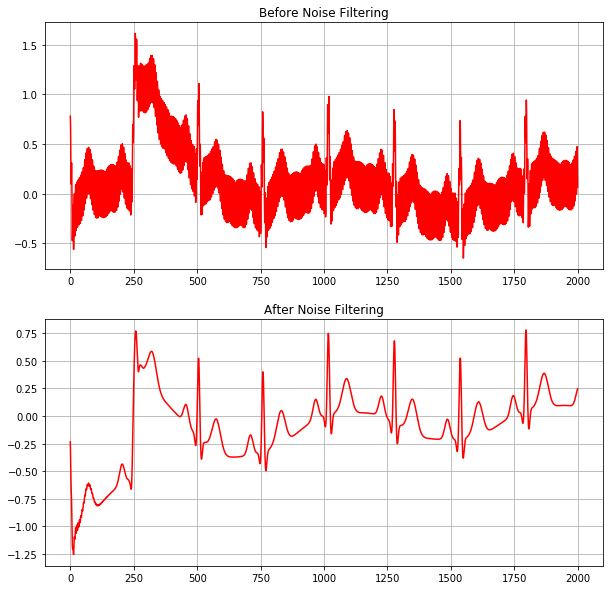

In [69]:
time_axis = np.linspace(0,2000, 2000);

noise_free_signals = filter_noise(signals, low_cut_frequncy,
                 high_cut_frequncy, sample_rate, frequency_to_remove)

figure, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].grid()
ax[0].plot(time_axis, signals[0:2000], color='red')
ax[0].title.set_text('Before Noise Filtering')

ax[1].plot(time_axis, noise_free_signals[0:2000], color='red')
ax[1].grid()
ax[1].title.set_text('After Noise Filtering')
figure.savefig('Before_After_Filter.jpg')

## ECG Signals With Different WIndow Sizes

In [45]:
filtered_signals = filter_noise(signals, low_cut_frequncy,
                 high_cut_frequncy, sample_rate, frequency_to_remove)

R5_peaks, smooth_filtered_5,_ = ECG_plotting_analysis(filtered_signals,5)
R15_peaks, smooth_filtered_15,_= ECG_plotting_analysis(filtered_signals,15)
R25_peaks, smooth_filtered_25, R25_indices= ECG_plotting_analysis(filtered_signals,25)

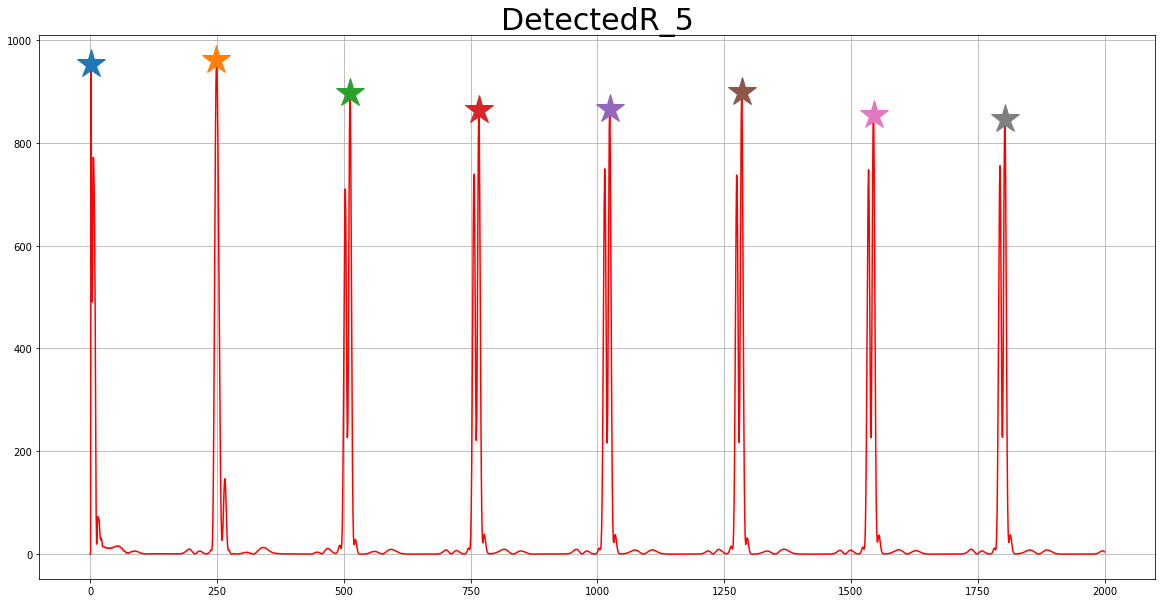

In [78]:
RR_figure, RR_ax = plt.subplots(figsize=(20, 10))
time = time_axis[0:2000]
smooth_filtered_5= smooth_filtered_5[0:2000]

RR_ax.plot(time,smooth_filtered_5, color='red')
RR_ax.set_title('DetectedR_5', fontsize= 30)
RR_ax.grid()
for i, v in enumerate(smooth_filtered_5):
        if v in R5_peaks:
            plt.plot(time[i], v,  marker='*', markersize=30)
            
RR_figure.savefig('DetectedR_5.jpg')

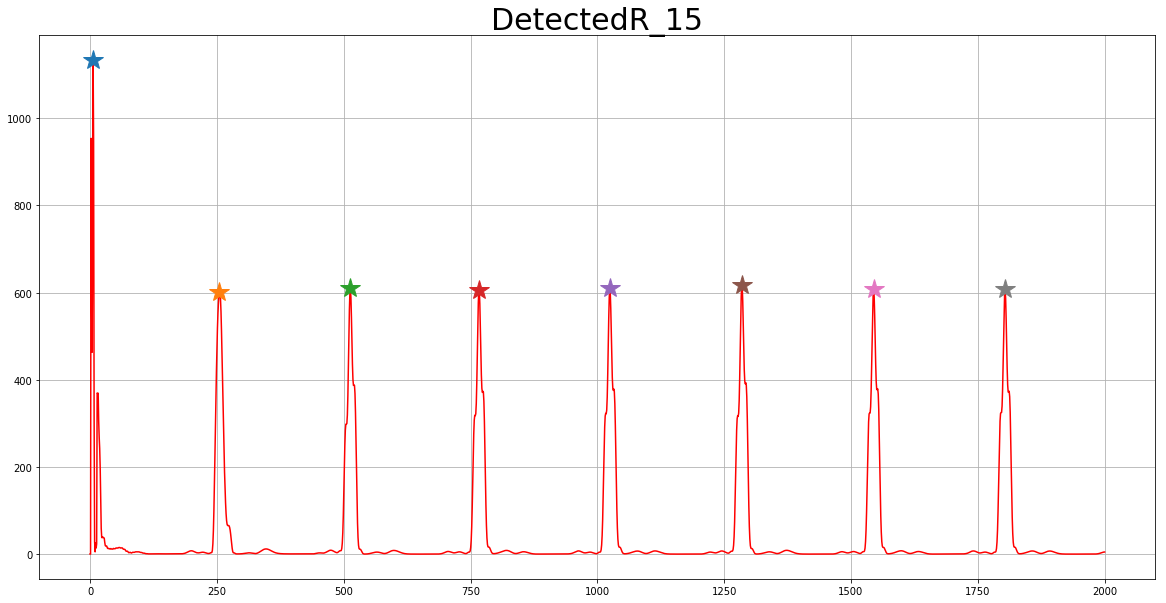

In [77]:
smooth_filtered_15 =smooth_filtered_15[0:2000]
RR15_figure, RR15_ax = plt.subplots(figsize=(20, 10))
RR15_ax.plot(time,smooth_filtered_15, color='red')
RR15_ax.set_title('DetectedR_15', fontsize= 30)
RR15_ax.grid()
for i, v in enumerate(smooth_filtered_15):
        if v in R15_peaks:
            plt.plot(time[i], v,  marker='*', markersize=20)
RR15_figure.savefig('DetectedR_15.jpg')

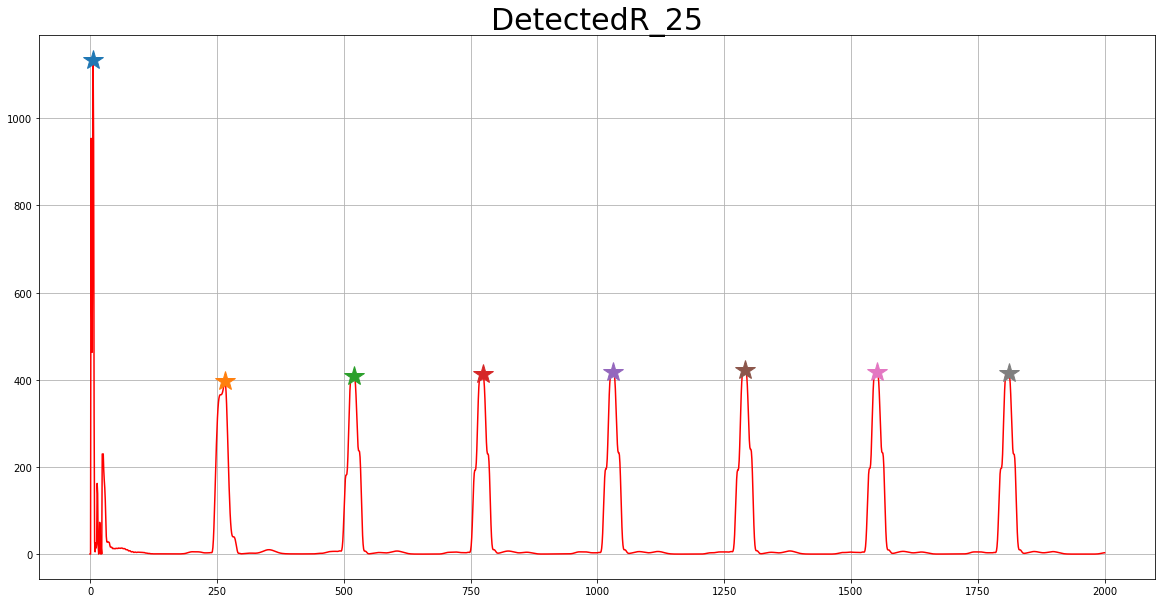

In [76]:
smooth_filtered_25 = smooth_filtered_25[0:2000]
RR25_figure, RR25_ax = plt.subplots(figsize=(20, 10))
RR25_ax.plot(time,smooth_filtered_25, color='red')
RR25_ax.set_title('DetectedR_25', fontsize= 30)
RR25_ax.grid()
for i, v in enumerate(smooth_filtered_25):
        if v in R25_peaks:
            plt.plot(time[i], v,  marker='*', markersize=20)
            
RR25_figure.savefig('DetectedR_25.jpg')

## What can you conclude about the optimal setting of N?

### Increasing the window size decreased the abrupt changes in the signals. By comparing the output signal of window size 5, 15 and 25, using 25 for a window size gave the smoothest signals and the peak became more aligned with the supposed position of the R wave. From this observation we deduce that a window size of 25 is the optimal window size.

## Thresholding Method

### The maximum value amongst smoothed signals was divided by the supplied window size to set a threhold for the R peak.  



## ECG Signals With Different WIndow Sizes, Without Noise Filtering

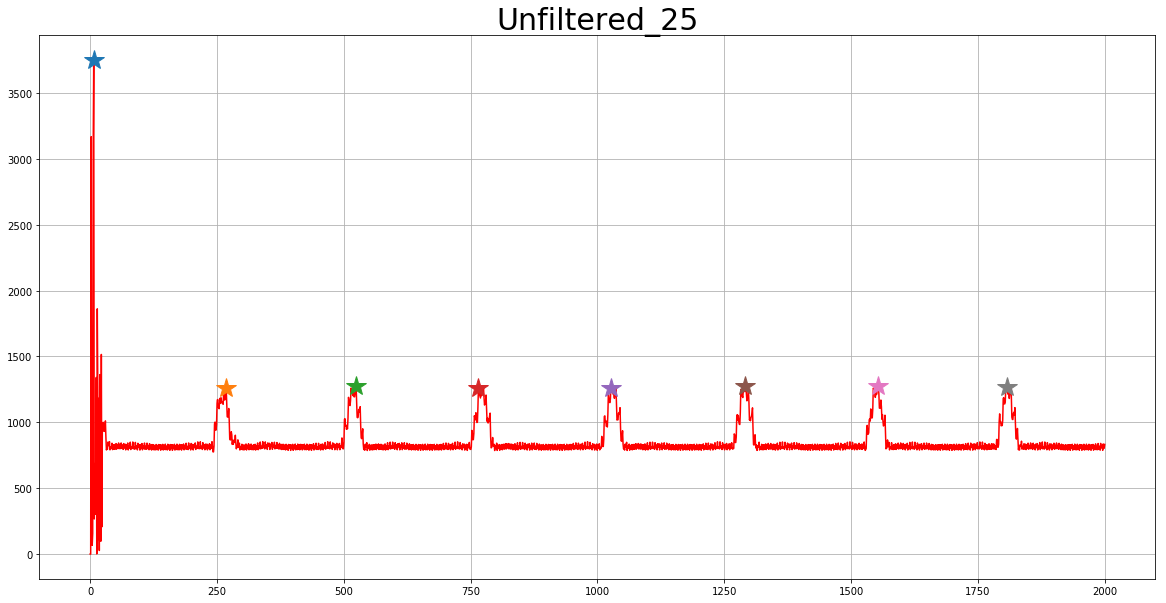

In [79]:
noisy_N25 = signals[0:2000]
R_peaks_with_noise, noisy_samples_N25,_ = ECG_plotting_analysis(signals, 25)
noisy_samples_N25= noisy_samples_N25[0:2000]

figure, ax = plt.subplots(figsize=(20, 10))
ax.plot(time,noisy_samples_N25, color='red')
ax.set_title('Unfiltered_25', fontsize= 30)
ax.grid()
for i, v in enumerate(noisy_samples_N25):
        if v in R_peaks_with_noise:
            plt.plot(time[i], v,  marker='*', markersize=20)
            
figure.savefig('Unfiltered_25.jpg')

## RR Intervals 

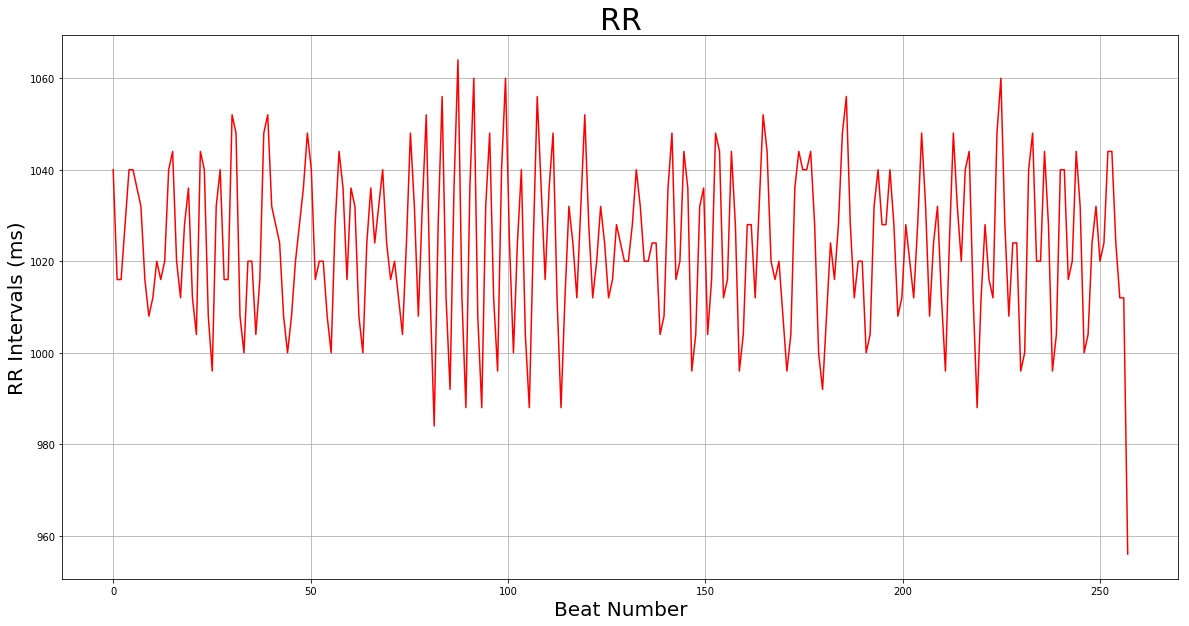

In [80]:
RR_intervals, _ = HRV(sample_rate, R25_indices[0])

beat_number = np.linspace(0, len(RR_intervals), len(RR_intervals))

RR_interval_figure, RR_interval_ax = plt.subplots(figsize=(20, 10))
RR_interval_ax.plot(beat_number,RR_intervals, color='red')
RR_interval_ax.set_title('RR', fontsize= 30)
RR_interval_ax.set_ylabel('RR Intervals (ms)', fontsize= 20)
RR_interval_ax.set_xlabel('Beat Number', fontsize= 20)
RR_interval_ax.grid()
 
RR_interval_figure.savefig('RR_interval_figure.jpg')

# Detecting Missing Beats

In [62]:
noise_free_signals = filter_noise(missing_beats_signals, low_cut_frequncy,
                high_cut_frequncy, sample_rate, 60)
detected_RR_interval, timestamps = ECG(noise_free_signals, 15)
RR_interval_average = np.mean(detected_RR_interval)

RR_interval_peaks = find_peaks(detected_RR_interval,height=RR_interval_average*1.5)[0]
RR_interval_values = R_peaks(detected_RR_interval, RR_interval_peaks)

missing_beats_timestamps = []


for RR_index in range(0, len(RR_interval_peaks)):
    missing_beat_timestamp = timestamps[RR_index]
    +timestamps[RR_index+1]
        
    missing_beat_timestamp/=2
        
    missing_beats_timestamps.append(missing_beat_timestamp)
    

In [56]:
np.savetxt('MissingBeats', missing_beats_timestamps)

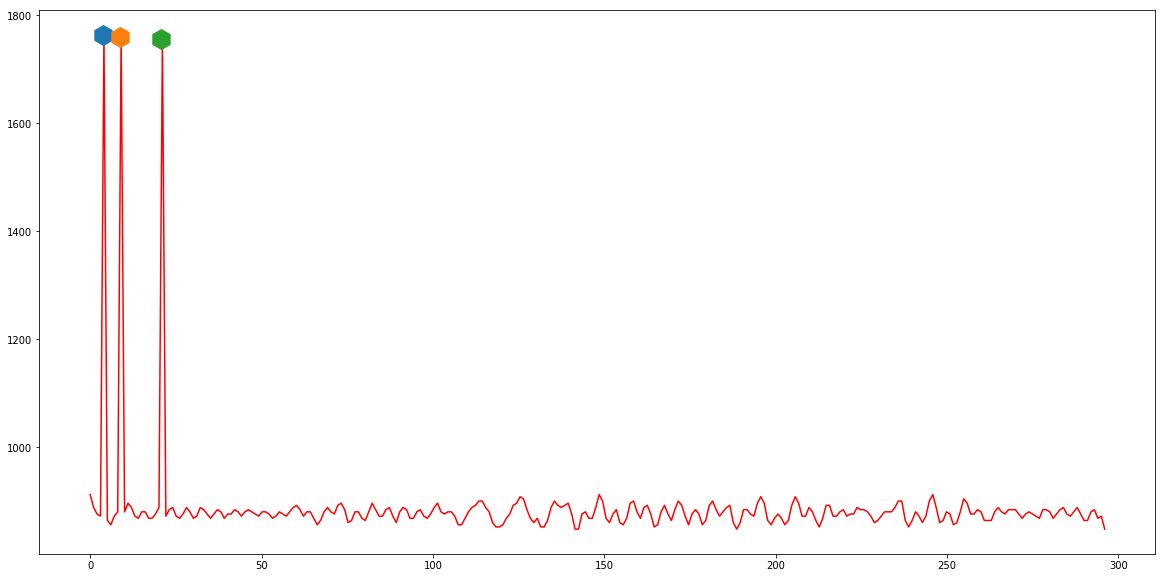

In [64]:
figure, interval_ax = plt.subplots(figsize=(20, 10))
beat_number = np.linspace(0, len(detected_RR_interval), len(detected_RR_interval))
interval_ax.plot(beat_number,detected_RR_interval, color='red')
for i, v in enumerate(detected_RR_interval):
        if v in RR_interval_values:
            plt.plot(beat_number[i]-0.4, v,  marker='h', markersize=20)